In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

In [2]:
gdf = pd.read_csv('census_block_loc.csv',
                 encoding= 'utf-8', na_values=[':'], low_memory=False)

In [3]:
gdf = gpd.GeoDataFrame(
    gdf, geometry=gpd.points_from_xy(gdf.Latitude, gdf.Longitude))
gdf.head()

Latitude  Longitude        BlockCode     County State  \
0     40.48 -74.280000  340230076002012  Middlesex    NJ   
1     40.48 -74.276834  340230076005000  Middlesex    NJ   
2     40.48 -74.273668  340230076003018  Middlesex    NJ   
3     40.48 -74.270503  340230076003004  Middlesex    NJ   
4     40.48 -74.267337  340230074021000  Middlesex    NJ   

                     geometry  
0  POINT (40.48000 -74.28000)  
1  POINT (40.48000 -74.27683)  
2  POINT (40.48000 -74.27367)  
3  POINT (40.48000 -74.27050)  
4  POINT (40.48000 -74.26734)

In [4]:
d = pd.read_csv('nyc_census_tracts.csv',
                 encoding= 'utf-8', na_values=[':'], low_memory=False)

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      2167 non-null   int64  
 1   County           2167 non-null   object 
 2   Borough          2167 non-null   object 
 3   TotalPop         2167 non-null   int64  
 4   Men              2167 non-null   int64  
 5   Women            2167 non-null   int64  
 6   Hispanic         2128 non-null   float64
 7   White            2128 non-null   float64
 8   Black            2128 non-null   float64
 9   Native           2128 non-null   float64
 10  Asian            2128 non-null   float64
 11  Citizen          2167 non-null   int64  
 12  Income           2101 non-null   float64
 13  IncomeErr        2101 non-null   float64
 14  IncomePerCap     2121 non-null   float64
 15  IncomePerCapErr  2121 non-null   float64
 16  Poverty          2125 non-null   float64
 17  ChildPoverty  

In [6]:
df = d[['CensusTract','Hispanic','White','Black','Native','Asian']]
df.head()

CensusTract  Hispanic  White  Black  Native  Asian
0  36005000100      29.9    6.1   60.9     0.2    1.6
1  36005000200      75.8    2.3   16.0     0.0    4.2
2  36005000400      62.7    3.6   30.7     0.0    0.3
3  36005001600      65.1    1.6   32.4     0.0    0.0
4  36005001900      55.4    9.0   29.0     0.0    2.1

In [7]:
df

CensusTract  Hispanic  White  Black  Native  Asian
0     36005000100      29.9    6.1   60.9     0.2    1.6
1     36005000200      75.8    2.3   16.0     0.0    4.2
2     36005000400      62.7    3.6   30.7     0.0    0.3
3     36005001600      65.1    1.6   32.4     0.0    0.0
4     36005001900      55.4    9.0   29.0     0.0    2.1
...           ...       ...    ...    ...     ...    ...
2162  36085030302      35.8   28.7   17.6     0.0   14.3
2163  36085031901      27.1    6.2   60.4     0.0    6.3
2164  36085031902      20.9   14.7   61.9     0.0    0.9
2165  36085032300      45.5   24.0   29.7     0.0    0.0
2166  36085990100       NaN    NaN    NaN     NaN    NaN

[2167 rows x 6 columns]

In [8]:
pd.isnull(df).sum() > 0

CensusTract    False
Hispanic        True
White           True
Black           True
Native          True
Asian           True
dtype: bool

In [9]:
print(df[df['Hispanic'].isnull()])

      CensusTract  Hispanic  White  Black  Native  Asian
97    36005016300       NaN    NaN    NaN     NaN    NaN
103   36005017100       NaN    NaN    NaN     NaN    NaN
180   36005024900       NaN    NaN    NaN     NaN    NaN
402   36047008600       NaN    NaN    NaN     NaN    NaN
452   36047015400       NaN    NaN    NaN     NaN    NaN
470   36047017500       NaN    NaN    NaN     NaN    NaN
472   36047017700       NaN    NaN    NaN     NaN    NaN
684   36047040700       NaN    NaN    NaN     NaN    NaN
879   36047066600       NaN    NaN    NaN     NaN    NaN
897   36047070203       NaN    NaN    NaN     NaN    NaN
1011  36047096000       NaN    NaN    NaN     NaN    NaN
1079  36047118000       NaN    NaN    NaN     NaN    NaN
1099  36047990100       NaN    NaN    NaN     NaN    NaN
1100  36061000100       NaN    NaN    NaN     NaN    NaN
1103  36061000500       NaN    NaN    NaN     NaN    NaN
1184  36061008602       NaN    NaN    NaN     NaN    NaN
1384  36061031100       NaN    

In [10]:
print(df.shape)
df = df.dropna()
print(df.shape)

(2167, 6)
(2128, 6)


In [11]:
df['total']=df['Hispanic']+df['White']+df['Black']+df['Native']+df['Asian']
df['Hispanic'] = round(df['Hispanic']/df['total'],5)
df['White'] = round(df['White']/df['total'],5)
df['Black'] = round(df['Black']/df['total'],5)
df['Native'] = round(df['Native']/df['total'],5)
df['Asian'] = round(df['Asian']/df['total'],5)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [12]:
df.sample()

CensusTract  Hispanic    White    Black  Native   Asian  total
1415  36081004001   0.51911  0.21762  0.02017     0.0  0.2431   94.2

In [13]:
gdf = gdf[gdf.County.isin(['Bronx','Kings','New York','Queens','Richmond'])]
gdf['Tract'] = gdf.BlockCode // 10000

ppd = pd.merge(gdf, df, left_on='Tract', right_on='CensusTract', how='inner').reset_index()
ppd.shape
ppd.sample(3)

index   Latitude  Longitude        BlockCode    County State  \
16        16  40.498090 -74.251508  360850244020003  Richmond    NY   
5101    5101  40.649598 -74.007739  360470082002001     Kings    NY   
12876  12876  40.911910 -73.909598  360050309001000     Bronx    NY   

                         geometry        Tract  CensusTract  Hispanic  \
16     POINT (40.49809 -74.25151)  36085024402  36085024402   0.03700   
5101   POINT (40.64960 -74.00774)  36047008200  36047008200   0.72782   
12876  POINT (40.91191 -73.90960)  36005030900  36005030900   0.11782   

         White    Black   Native    Asian  total  
16     0.84500  0.00600  0.00000  0.11200  100.0  
5101   0.10484  0.01210  0.00000  0.15524   99.2  
12876  0.77341  0.06042  0.00705  0.04129   99.3

In [14]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [15]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

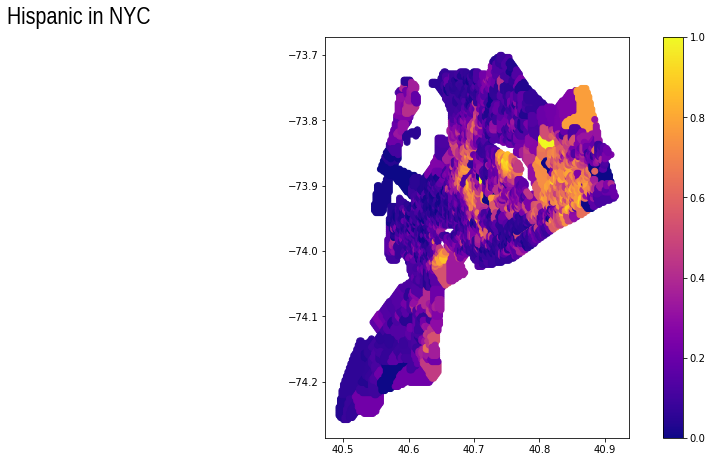

In [16]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='Hispanic', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Hispanic in NYC", x=0.025, size=24, **tfont);
#plt.savefig('Cluster_IMD_Score_Raw.png', dpi=150)

In [17]:
ppd = ppd[['Tract','geometry','Hispanic','White','Black','Native','Asian']].copy()
ppd.head()

Tract                    geometry  Hispanic  White  Black  Native  \
0  36085024402  POINT (40.49357 -74.25151)     0.037  0.845  0.006     0.0   
1  36085024402  POINT (40.49357 -74.24834)     0.037  0.845  0.006     0.0   
2  36085024402  POINT (40.49357 -74.24518)     0.037  0.845  0.006     0.0   
3  36085024402  POINT (40.49357 -74.24201)     0.037  0.845  0.006     0.0   
4  36085024402  POINT (40.49357 -74.23884)     0.037  0.845  0.006     0.0   

   Asian  
0  0.112  
1  0.112  
2  0.112  
3  0.112  
4  0.112

In [18]:
to_cluster = ppd[['Tract','Hispanic','White','Black','Native','Asian']].set_index('Tract').copy()
to_cluster.head()

Hispanic  White  Black  Native  Asian
Tract                                             
36085024402     0.037  0.845  0.006     0.0  0.112
36085024402     0.037  0.845  0.006     0.0  0.112
36085024402     0.037  0.845  0.006     0.0  0.112
36085024402     0.037  0.845  0.006     0.0  0.112
36085024402     0.037  0.845  0.006     0.0  0.112

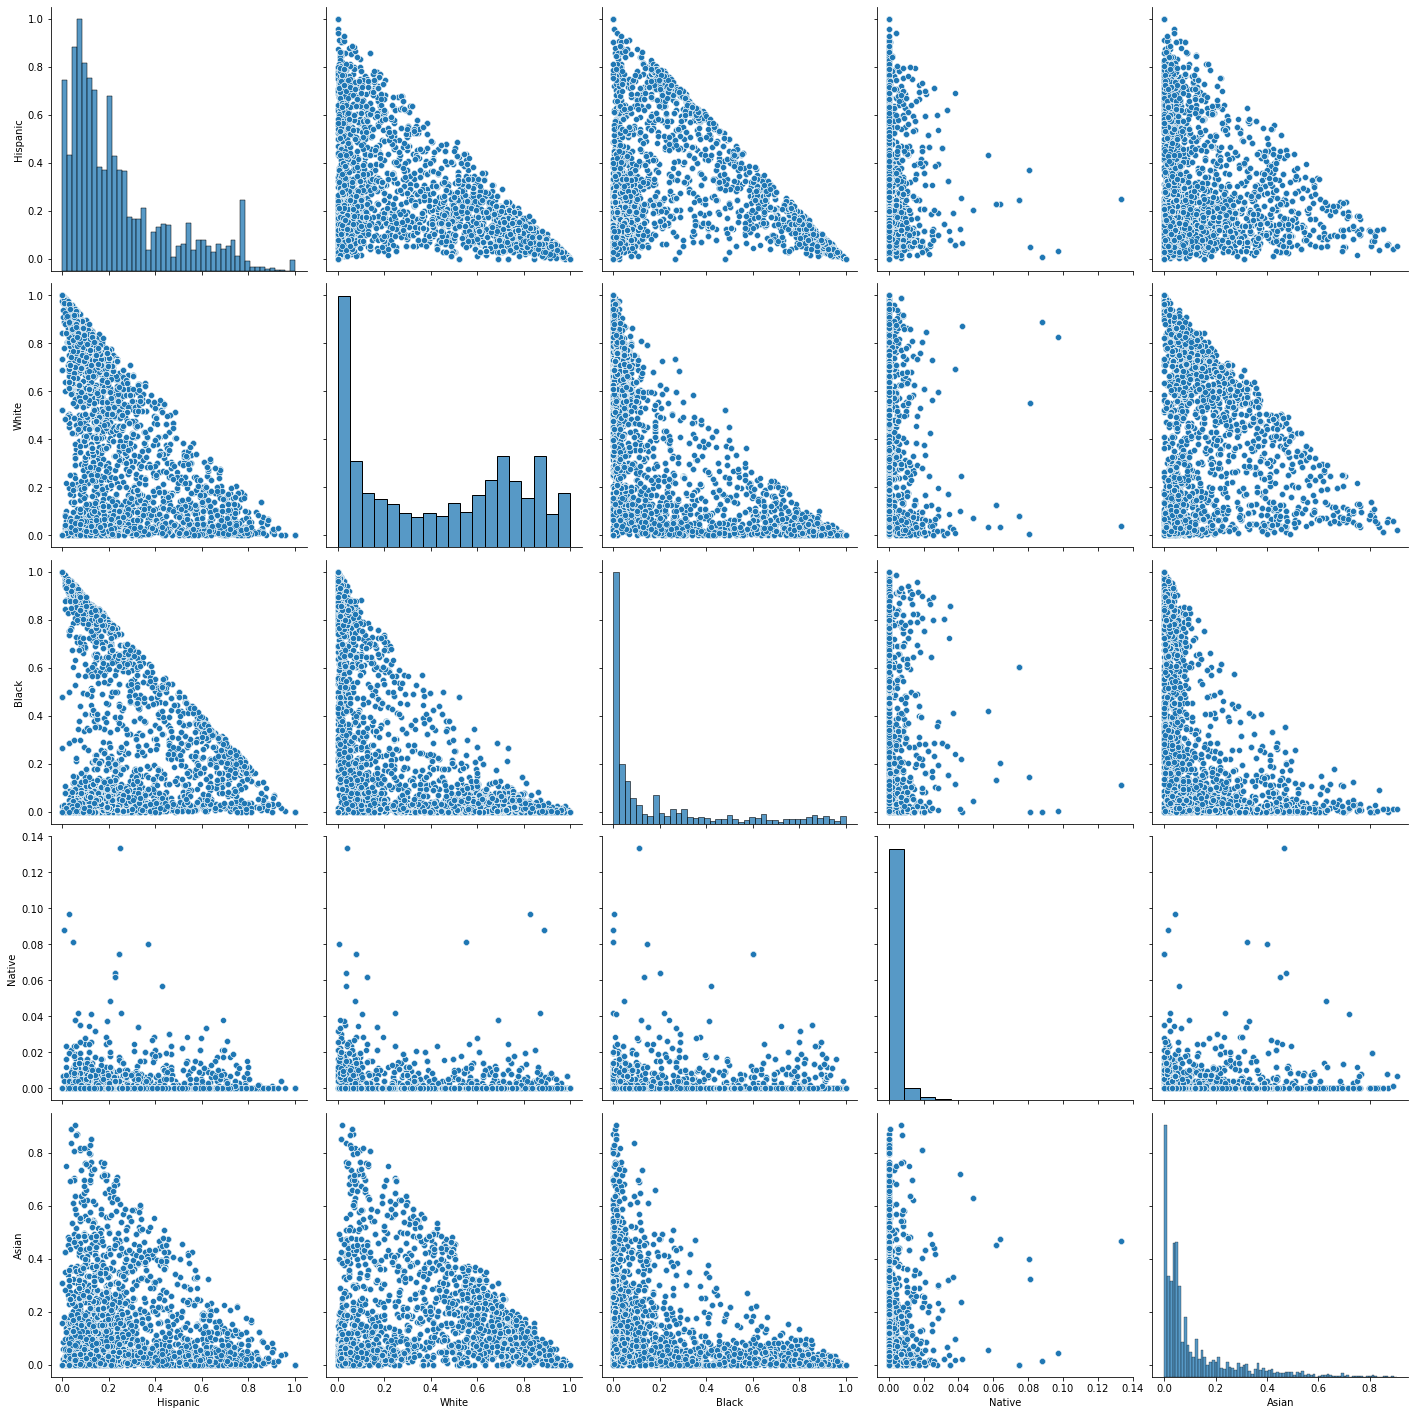

In [19]:
plot_norm = sns.pairplot(to_cluster,height = 4)

In [20]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

Hispanic     White     Black    Native     Asian
Tract                                                        
36061015200  0.343610  0.428173 -0.040463 -0.517019  0.401947
36081118700  0.491186 -0.851462 -1.018457 -0.517019  1.868913
36081091601 -1.535463  1.531604 -1.031880 -0.517019 -1.289117
36081035200 -0.975173 -1.226492  1.705201 -0.517019 -1.214014
36047086000 -0.398922 -1.368146  1.689858 -0.517019 -0.946057

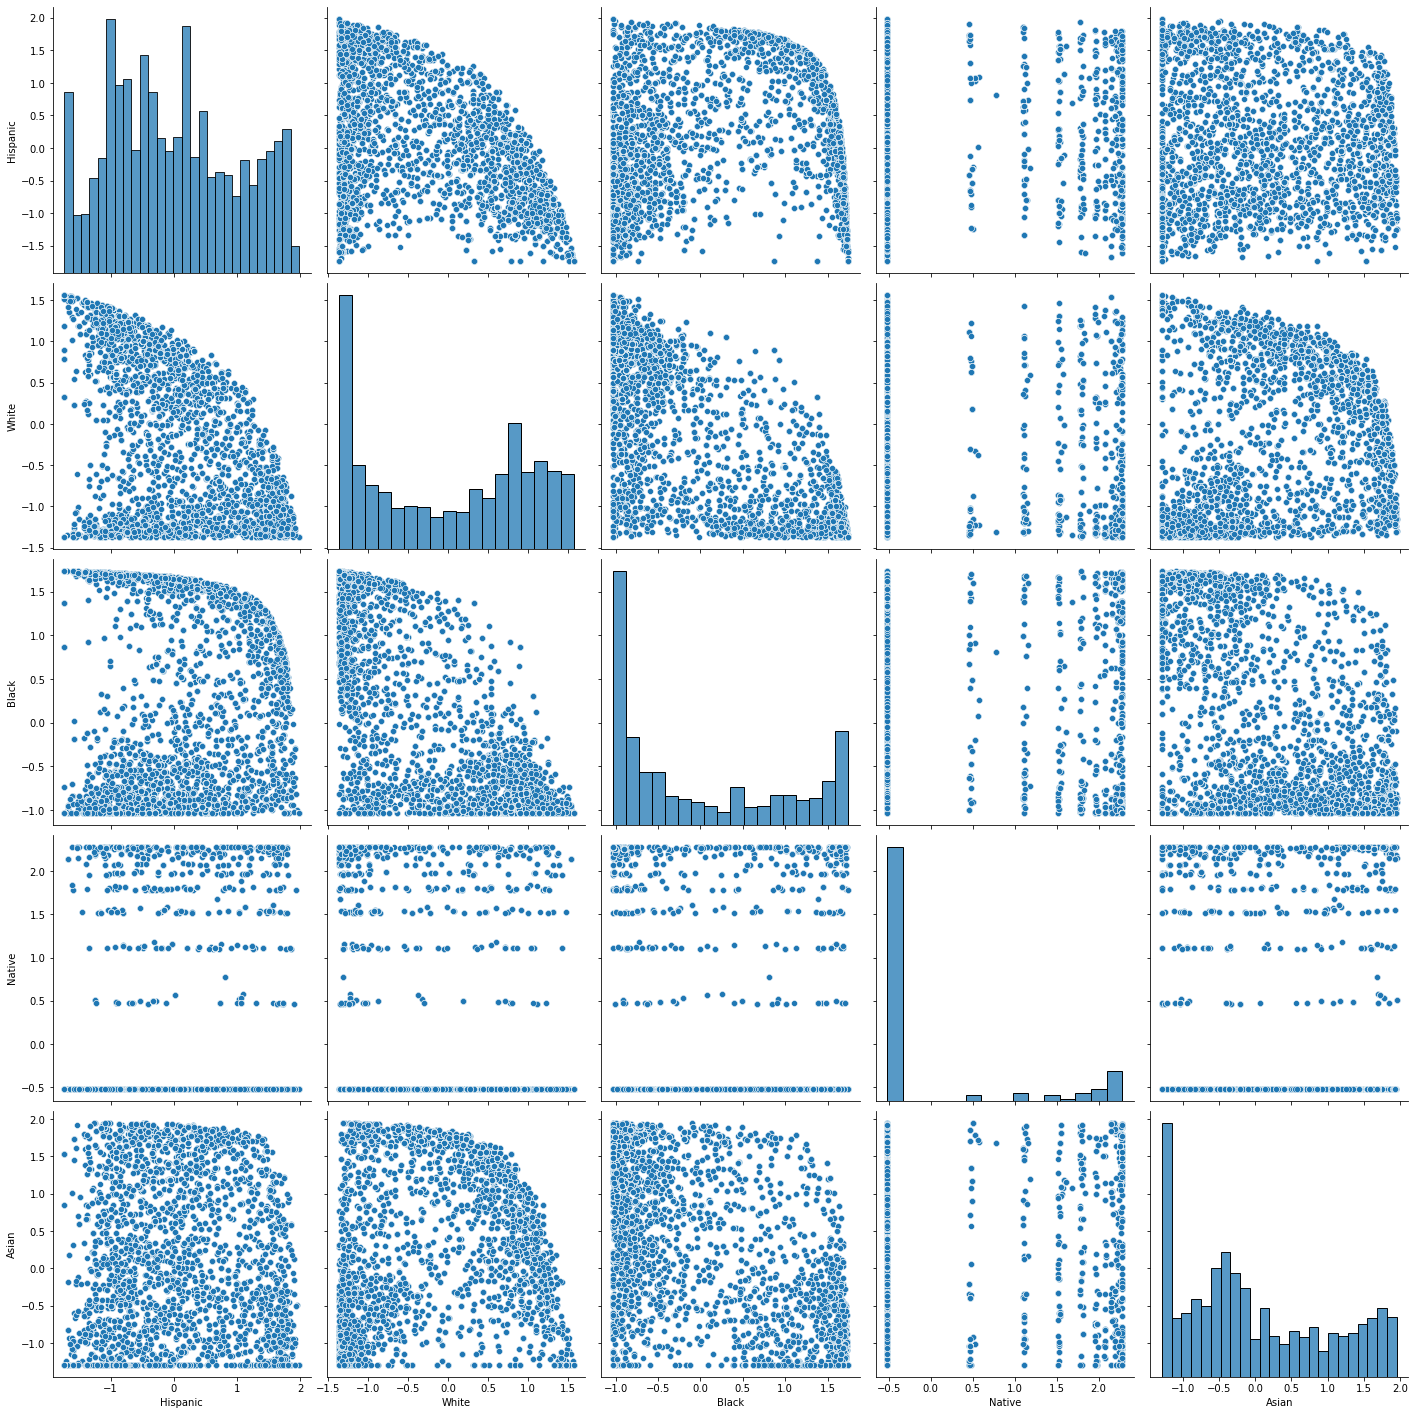

In [21]:
plot_norm = sns.pairplot(normed,height = 4)

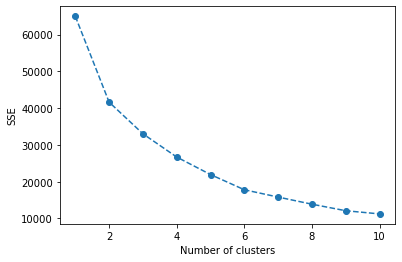

In [22]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(normed)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [23]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=2, random_state=1)

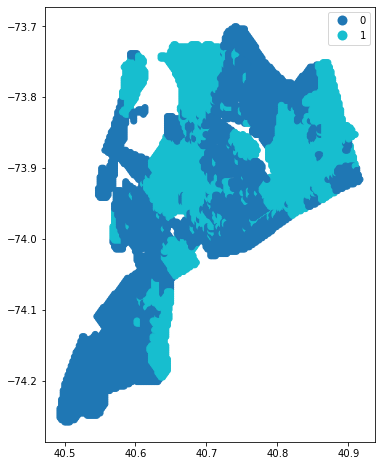

In [24]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

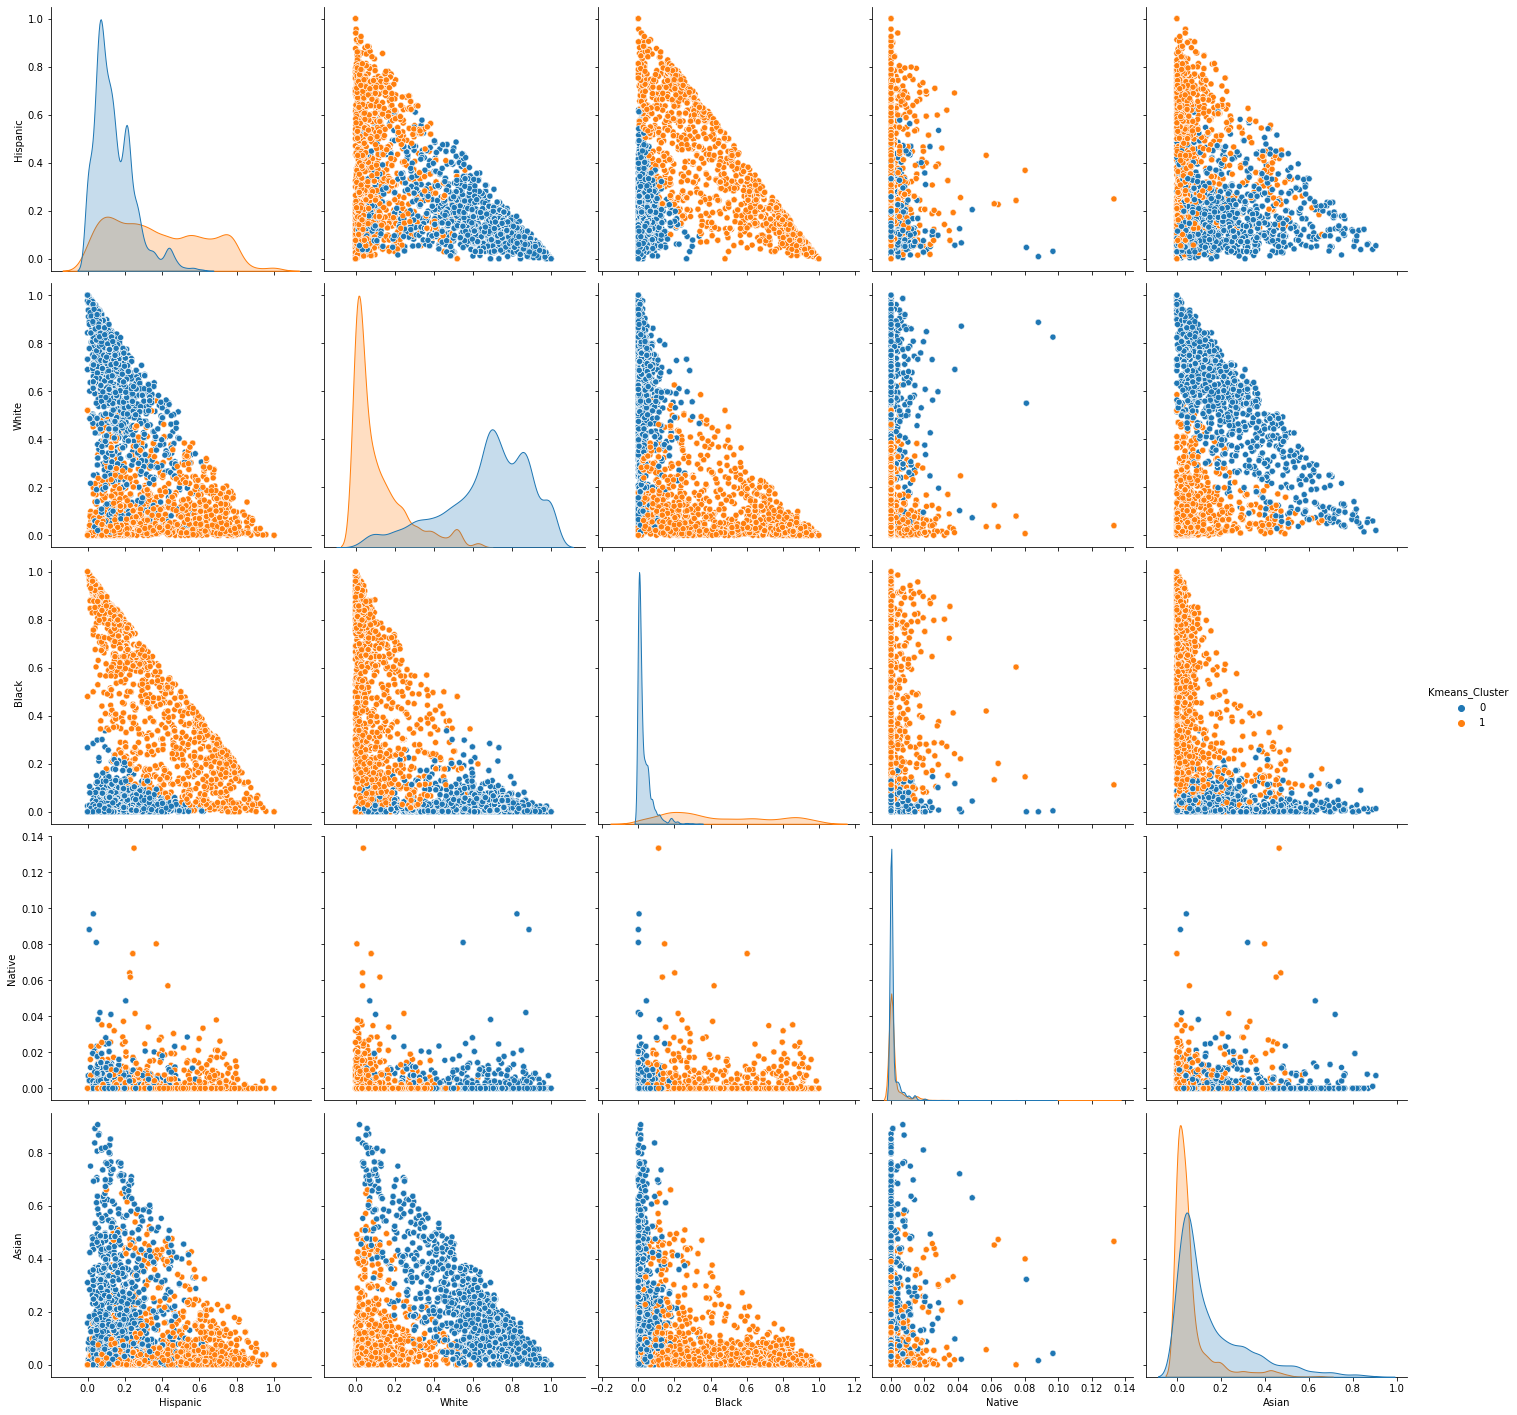

In [25]:
ppdp = ppd.drop(['Tract'],axis = 1)
plot_norm = sns.pairplot(ppdp,hue = 'Kmeans_Cluster',height = 4)

In [26]:
ppcp = ppd[['Tract','Hispanic','White','Black','Native','Asian']].copy()
ppc = d[['CensusTract','Income','Poverty','Unemployment']]
ppc.head()

CensusTract   Income  Poverty  Unemployment
0  36005000100      NaN      NaN           NaN
1  36005000200  72034.0     20.0           7.7
2  36005000400  74836.0     13.2           9.5
3  36005001600  32312.0     26.3           8.7
4  36005001900  37936.0     37.1          19.2

In [27]:
print(ppc.shape)
ppc = ppc.dropna()
print(ppc.shape)

(2167, 4)
(2101, 4)


In [28]:
dfcor = pd.merge(ppcp, ppc, left_on='Tract', right_on='CensusTract', how='inner').reset_index()
dfcor.sample(3)

index        Tract  Hispanic    White    Black  Native    Asian  \
752     752  36085017010   0.12700  0.81400  0.00200   0.001  0.05600   
9357   9357  36081099704   0.11794  0.66129  0.00706   0.000  0.21371   
6724   6724  36081061301   0.34211  0.56781  0.00911   0.000  0.08097   

      CensusTract   Income  Poverty  Unemployment  
752   36085017010  90747.0      7.7           6.8  
9357  36081099704  67131.0      9.8           6.1  
6724  36081061301  52153.0     20.5           8.4

In [29]:
to_corr = dfcor[['Tract','Hispanic','White','Black','Native','Asian','Income','Poverty','Unemployment']].set_index('Tract').copy()
to_corr.head()

Hispanic  White  Black  Native  Asian   Income  Poverty  \
Tract                                                                  
36085024402     0.037  0.845  0.006     0.0  0.112  75167.0      6.5   
36085024402     0.037  0.845  0.006     0.0  0.112  75167.0      6.5   
36085024402     0.037  0.845  0.006     0.0  0.112  75167.0      6.5   
36085024402     0.037  0.845  0.006     0.0  0.112  75167.0      6.5   
36085024402     0.037  0.845  0.006     0.0  0.112  75167.0      6.5   

             Unemployment  
Tract                      
36085024402           8.3  
36085024402           8.3  
36085024402           8.3  
36085024402           8.3  
36085024402           8.3

In [30]:
to_corr['diversity'] = 1 - ((to_corr['White']**2 + to_corr['Black']**2 + to_corr['Native']**2 + to_corr['Asian']**2) * (to_corr['Hispanic']**2 + (1-to_corr['Hispanic'])**2))

In [31]:
to_corr_normed = to_corr.copy()
for c in to_corr.columns.values:
    to_corr_normed[c] = pts.fit_transform(to_corr[c].values.reshape(-1,1))
to_corr_normed.sample(5)

Hispanic     White     Black    Native     Asian    Income  \
Tract                                                                     
36047034900 -0.506044 -1.241328  1.674623  1.104418 -1.191489 -1.472475   
36061022301  1.801985 -0.943799 -0.040106 -0.520401 -0.623334 -1.096191   
36061003100 -0.920134  0.530539 -0.193901  1.806564  1.251539  3.464547   
36005046202  0.554298 -1.317558  1.596862  2.188630 -1.126763 -0.959411   
36081053601 -0.278989 -1.398047  1.661503  2.275157 -0.861320  0.060454   

              Poverty  Unemployment  diversity  
Tract                                           
36047034900  1.280527      0.280679  -0.867489  
36061022301  0.914616      0.339480   1.601870  
36061003100  0.077027      0.840945  -0.132958  
36005046202  0.610944      0.857494   0.186815  
36081053601 -0.780516      0.670715  -0.639833

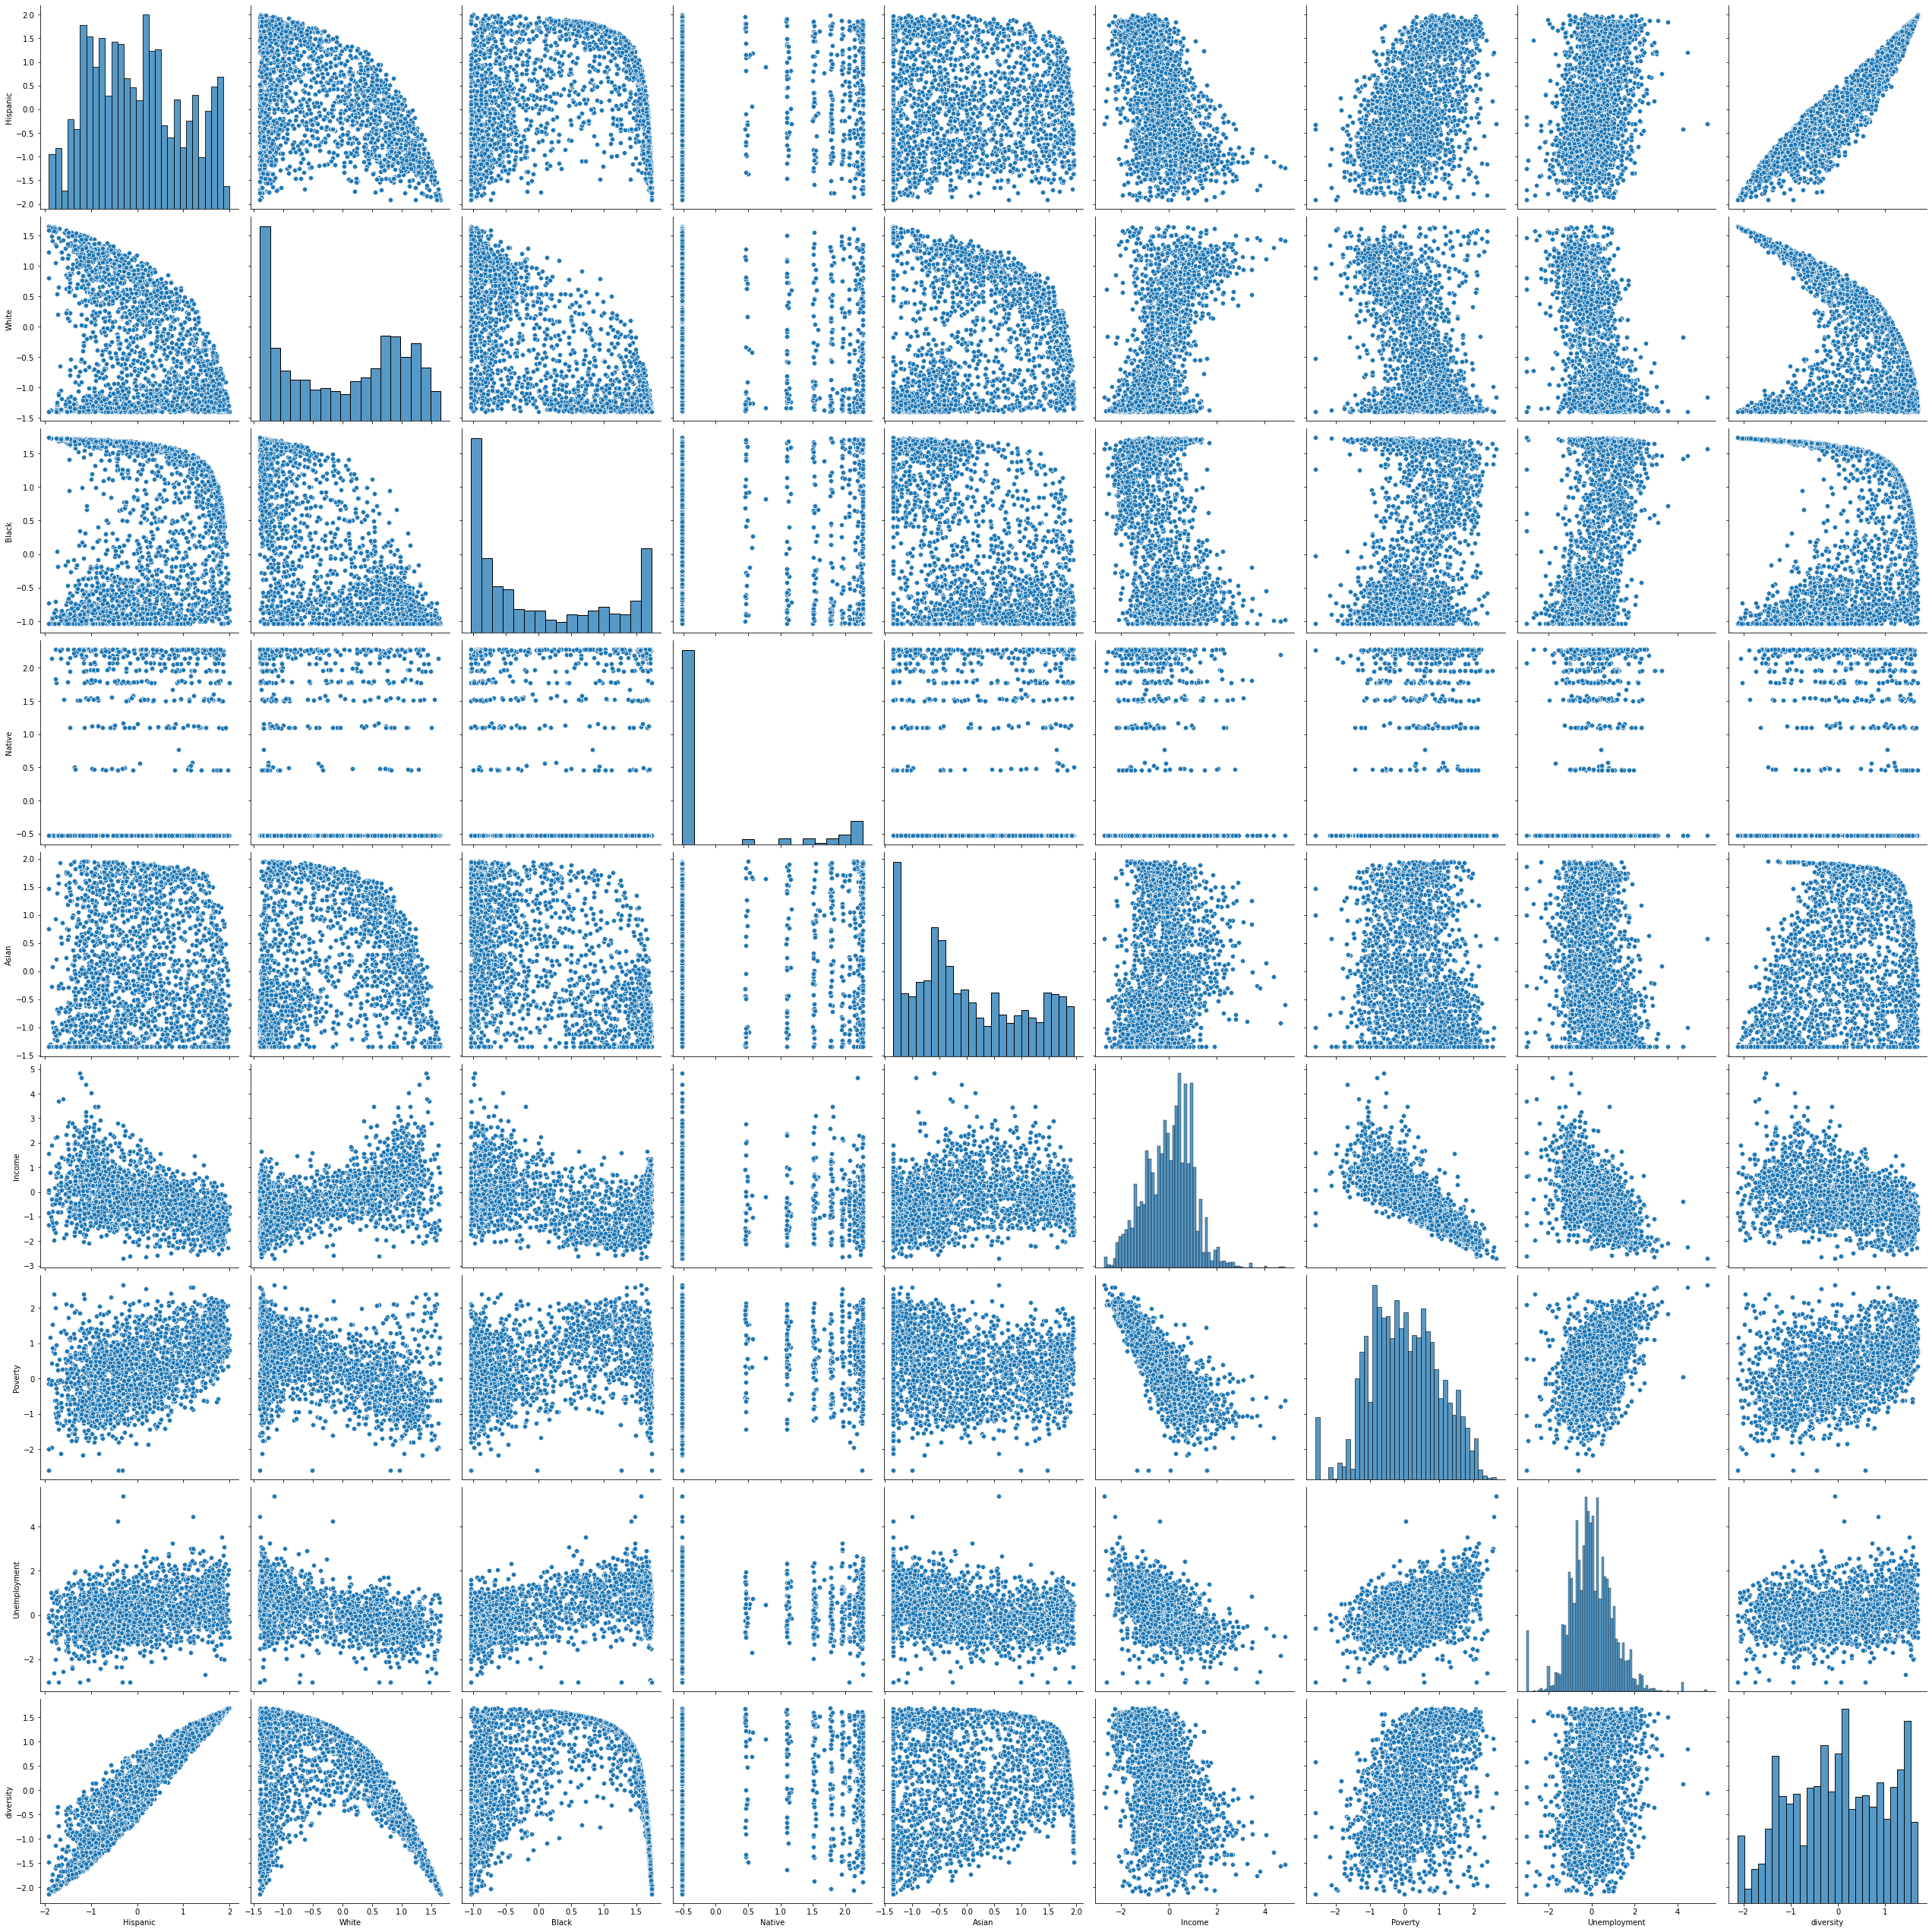

In [32]:
plot_norm = sns.pairplot(to_corr_normed,height = 4)

Text(0.5, 1.0, 'Correlation Matrix')

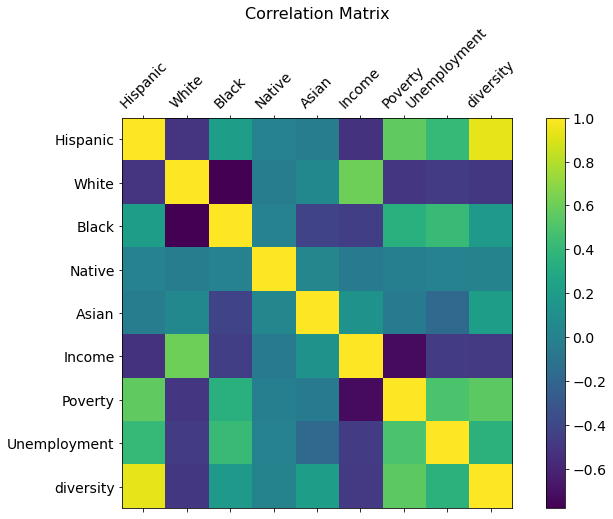

In [33]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 7))
plt.matshow(to_corr_normed.corr(), fignum=f.number)
plt.xticks(range(to_corr_normed.shape[1]), to_corr_normed.columns, fontsize=14, rotation=45)
plt.yticks(range(to_corr_normed.shape[1]), to_corr_normed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [38]:
to_corr_normed = to_corr_normed[['diversity','Income','Poverty','Unemployment']]

Text(0.5, 1.0, 'Correlation Matrix')

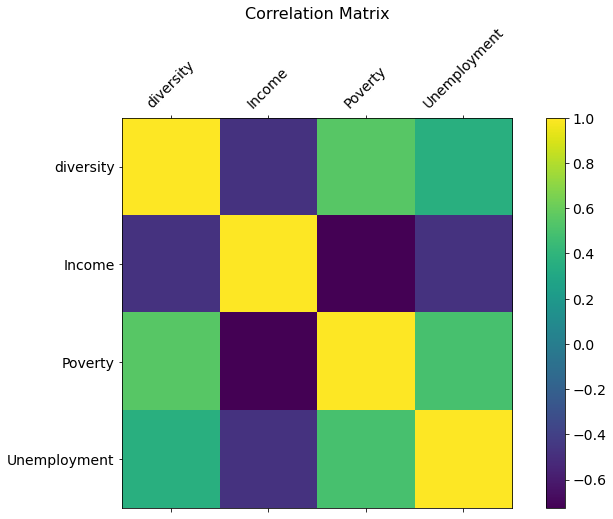

In [39]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 7))
plt.matshow(to_corr_normed.corr(), fignum=f.number)
plt.xticks(range(to_corr_normed.shape[1]), to_corr_normed.columns, fontsize=14, rotation=45)
plt.yticks(range(to_corr_normed.shape[1]), to_corr_normed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     3487.
Date:                Sun, 25 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:13:19   Log-Likelihood:                -15422.
No. Observations:               11947   AIC:                         3.085e+04
Df Residuals:                   11945   BIC:                         3.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.993e-16      0.008  -9.93e-14      1.0

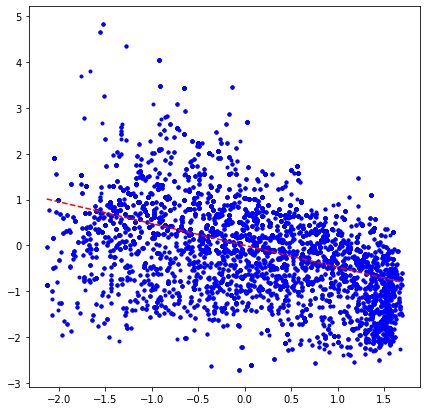

In [40]:
x_values = to_corr_normed['diversity']
y_values = to_corr_normed['Income']

# These lines perform the regression procedure:
X_values = sm.add_constant(x_values)
regression_model_a = sm.OLS(y_values, X_values)
regression_model_b = regression_model_a.fit()
# and print a summary of the results:
print(regression_model_b.summary())
print() # blank line

# Now we store all the relevant values:
gradient  = regression_model_b.params[1]
intercept = regression_model_b.params[0]
Rsquared  = regression_model_b.rsquared
MSE       = regression_model_b.mse_resid
pvalue    = regression_model_b.f_pvalue

# And print them:
print("gradient  =", regression_model_b.params[1])
print("intercept =", regression_model_b.params[0])
print("Rsquared  =", regression_model_b.rsquared)
print("MSE       =", regression_model_b.mse_resid)
print("pvalue    =", regression_model_b.f_pvalue)

# This line creates the endpoints of the best-fit line:
x_lobf = [min(x_values),max(x_values)]
y_lobf = [x_lobf[0]*gradient + intercept,x_lobf[1]*gradient + intercept]

# This line creates the figure. 
plt.figure(figsize=(7,7))

# Uncomment these lines to set the axis limits (otherwise they will be set automatically):
#x_min,x_max = 0,5000000
#y_min,y_max = 0,5000000
#plt.xlim([x_min,x_max])
#plt.ylim([y_min,y_max])

# The next lines create and save the plot:
plt.plot(x_values,y_values,'b.',x_lobf,y_lobf,'r--')